In [1]:
from utils.Tokenizer import RandomCropTokenizer, MAX_LEN, Tokenizer
from utils.StockDataset import StockDataset
from utils.DataReader import DataReader
from utils.Inference import Inference
from utils.Train import train_step, vaild_step
from utils.Ifttt import Ifttt
from utils.Loss import MyLoss
from models.LSTMDecoder import LSTMDecoder

import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import DataLoader

D:\ProgramData\Anaconda3\envs\gpsm2\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  RequestsDependencyWarning,


# Check dataset

In [2]:
tk_test = Tokenizer(grid=100, maxlen=MAX_LEN)
train_ds = StockDataset("data/train", r"*/*.yaml", tokenizer=tk_test)
train_ds.checkds()

Checking dataset in [data/train], include [4829] samples.
The min seqlen of data is [31], sample which under this standard would be removed.


100%|█████████████████████████████████████████████████████████████████████████████| 4829/4829 [00:37<00:00, 128.83it/s]

Done. [0] sample(s) removed.


In [3]:
tk_train = RandomCropTokenizer(grid=100, maxlen=MAX_LEN, minlen=10)
train_ds = StockDataset("data/train", r"*/*.yaml", tokenizer=tk_train)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

for b in train_dl:
    break
b, len(train_ds)

([tensor([[36, 36, 56,  ...,  0,  0,  0],
          [79, 79, 38,  ...,  0,  0,  0],
          [47, 47, 64,  ...,  0,  0,  0],
          ...,
          [46, 46, 68,  ...,  0,  0,  0],
          [31, 31, 28,  ...,  0,  0,  0],
          [35, 35, 48,  ...,  0,  0,  0]]),
  tensor([25, 59, 14, 43, 73, 38, 47, 53, 61, 42, 59, 67, 21, 23, 70, 42, 66, 53,
          14, 60, 17, 26, 33, 75, 58, 73, 15, 49, 12, 74, 33, 63, 47, 70, 21, 20,
          18, 50, 75, 72, 29, 30, 68, 45, 58, 61, 65, 72, 63, 39, 33, 60, 64, 44,
          24, 47, 70, 68, 39, 34, 20, 15, 32, 40, 25, 48, 70, 17, 42, 67, 74, 18,
          16, 71, 46, 70, 70, 42, 68, 64, 64, 70, 36, 16, 39, 37, 13, 17, 26, 71,
          30, 49, 39, 30, 52, 22, 64, 38, 26, 39, 43, 11, 68, 42, 70, 53, 73, 59,
          31, 12, 73, 18, 26, 18, 46, 16, 35, 30, 41, 64, 40, 28, 16, 15, 52, 48,
          21, 29])],
 4829)

# Load Model

In [4]:
device = torch.device("cuda")
model = LSTMDecoder(vocab_size=102, hidden_dim=512, layer=2, bi=True, device=device)
model = torch.load("checkpoints/model-pretrained.pt")
criterion = nn.KLDivLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
LSTMDecoder                              --
├─Embedding: 1-1                         52,224
├─Linear: 1-2                            52,736
├─Linear: 1-3                            52,736
├─LSTM: 1-4                              10,502,144
├─Linear: 1-5                            104,550
├─Dropout: 1-6                           --
Total params: 10,764,390
Trainable params: 10,764,390
Non-trainable params: 0

# Train

# Inference

In [5]:
import matplotlib.pyplot as plt
model = torch.load("checkpoints/model-pretrained.pt")
inference = Inference(model=model)

In [6]:
def plot_future(history, future_3=None, future_5=None, future_10=None, future_greedy=None, max_step=10):
    fig = plt.figure(figsize=[10, 5])
    xmax = len(history) + max_step
    if future_10:
        future_min, future_max = 1e9, -1e9
        for i in range(len(future_10)):
            pred_curve = history + future_10[i][:xmax]
            pred_curve = inference.postprocess([pred_curve])[0]
            plt.plot(pred_curve, label="pred", color="#1b7c3d")
            future_min, future_max = min(future_min, pred_curve[-1]), max(future_max, pred_curve[-1])
        vline10 = plt.vlines(len(history)-1 + 10, 0, future_max, linestyles ="dashed", colors ="#1b7c3d") 
        plt.vlines(len(history)-1 + 10, 0, future_min, linestyles ="dashed", colors ="#1b7c3d") 
    if future_5:
        future_min, future_max = 1e9, -1e9
        for i in range(len(future_5)):
            pred_curve = history + future_5[i][:xmax]
            pred_curve = inference.postprocess([pred_curve])[0]
            plt.plot(pred_curve, label="pred", color="#2b6a99")   
            future_min, future_max = min(future_min, pred_curve[-1]), max(future_max, pred_curve[-1])
        vline5 = plt.vlines(len(history)-1 + 5, 0, future_max, linestyles ="dashed", colors ="#2b6a99")     
        plt.vlines(len(history)-1 + 5, 0, future_min, linestyles ="dashed", colors ="#2b6a99")
    if future_3:
        future_min, future_max = 1e9, -1e9
        for i in range(len(future_3)):
            pred_curve = history + future_3[i][:xmax]
            pred_curve = inference.postprocess([pred_curve])[0]
            plt.plot(pred_curve, label="pred", color="#f16c23")   
            future_min, future_max = min(future_min, pred_curve[-1]), max(future_max, pred_curve[-1])
        vline3 = plt.vlines(len(history)-1 + 3, 0, future_max, linestyles ="dashed", colors ="#f16c23")
        plt.vlines(len(history)-1 + 3, 0, future_min, linestyles ="dashed", colors ="#f16c23")
        
    if future_greedy:
        future_min, future_max = 1e9, -1e9
        for i in range(len(future_greedy)):
            pred_curve = history + future_greedy[i][:xmax]
            pred_curve = inference.postprocess([pred_curve])[0]
            plt.plot(pred_curve, label="pred", color="#f16c23")   
            future_min, future_max = min(future_min, pred_curve[-1]), max(future_max, pred_curve[-1])
        vlinegd = plt.vlines(len(history)-1 + len(future_greedy[i][:xmax]), 0, future_max, linestyles ="dashed", colors ="#f16cca")
        plt.vlines(len(history)-1 + len(future_greedy[i][:xmax]), 0, future_min, linestyles ="dashed", colors ="#f16cca")
        
    history = inference.postprocess([history])[0]
    today = plt.vlines(len(history)-1, 0, history[-1], colors ="gray")    
    handles, labels = [today], ['today']
    if future_3: handles.append(vline3), labels.append('+3days')
    if future_5: handles.append(vline5), labels.append('+5days')
    if future_10: handles.append(vline10), labels.append('+10days')
    if future_greedy: handles.append(vlinegd), labels.append(f'greedy search: +{len(future_greedy[i][:xmax])} days')
    plt.legend(handles=handles, labels=labels, loc='best')   
    
    plt.plot(history, color="black")    
    plt.xlim([0, xmax])
    plt.xlabel("Time Step")
    plt.ylabel("Change %")
    plt.title("Prediction")
    plt.grid()
    plt.show()
    
    return fig

## Greedy Search

In [ ]:
model.eval()
with torch.no_grad():
    data = train_ds.reader.readyaml("D:/JupyterProjects/lstm-ar-stock-predict/data/test/300308.yaml")
    today = data["end"]
    seq_raw = data["stdchange"]
    seq, seqlen = tk_test.tokenize(seq_raw)
    seq = torch.Tensor(seq).long().to(device)
    
    pred, _, _ = inference.greedy_search(seq.to(device), seqlen, predict_step=30)
    seq = seq.cpu().numpy().tolist()
    
    fig = plot_future(history=seq[1: 1+seqlen], future_greedy=pred, max_step=30)
    fig.savefig('img/300308_gs.svg', format='svg')

## Beam Search

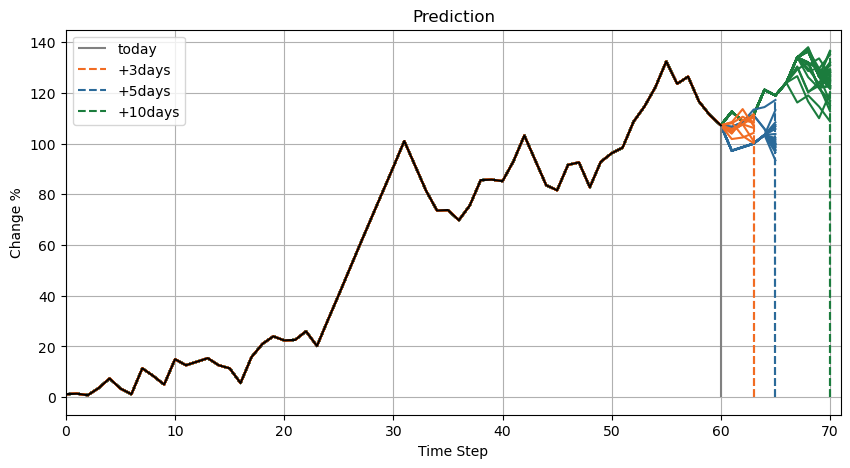

In [8]:
model.eval()
with torch.no_grad():
    data = train_ds.reader.readyaml("D:/JupyterProjects/lstm-ar-stock-predict/data/test/002786.yaml")
    today = data["end"]
    seq_raw = data["stdchange"]
    seq, seqlen = tk_test.tokenize(seq_raw)
    seq = torch.Tensor(seq).long().to(device)
    
    preds_3, _, _ = inference.beam_search(seq.to(device), seqlen, beam_size=10, predict_step=3)
    preds_5, _, _ = inference.beam_search(seq.to(device), seqlen, beam_size=20, predict_step=5)
    preds_10, _, _ = inference.beam_search(seq.to(device), seqlen, beam_size=50, predict_step=10)
    seq = seq.cpu().numpy().tolist()
    
    fig = plot_future(history=seq[1: 1+seqlen], future_3=preds_3, future_5=preds_5, future_10=preds_10, max_step=10)
    fig.savefig('img/002786_bs.svg', format='svg')